In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [1]:
import math
from collections import OrderedDict
from functools import partial
from typing import Any, Callable, Dict, List, NamedTuple, Optional

import torch
import torch.nn as nn

from  torchvision.ops.misc import Conv2dNormActivation, MLP
from torchvision.transforms._presets import ImageClassification, InterpolationMode
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface
from torchvision.models.vision_transformer import ViT_B_16_Weights


__all__ = [
    "VisionTransformer",
    "ViT_B_16_Weights",
    "ViT_B_32_Weights",
    "ViT_L_16_Weights",
    "ViT_L_32_Weights",
    "ViT_H_14_Weights",
    "vit_b_16",
    "vit_b_32",
    "vit_l_16",
    "vit_l_32",
    "vit_h_14",
]


class ConvStemConfig(NamedTuple):
    out_channels: int
    kernel_size: int
    stride: int
    norm_layer: Callable[..., nn.Module] = nn.BatchNorm2d
    activation_layer: Callable[..., nn.Module] = nn.ReLU


class MLPBlock(MLP):
    """Transformer MLP block."""

    _version = 2

    def __init__(self, in_dim: int, mlp_dim: int, dropout: float):
        super().__init__(in_dim, [mlp_dim, in_dim], activation_layer=nn.GELU, inplace=None, dropout=dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            # Replacing legacy MLPBlock with MLP. See https://github.com/pytorch/vision/pull/6053
            for i in range(2):
                for type in ["weight", "bias"]:
                    old_key = f"{prefix}linear_{i+1}.{type}"
                    new_key = f"{prefix}{3*i}.{type}"
                    if old_key in state_dict:
                        state_dict[new_key] = state_dict.pop(old_key)

        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )


class EncoderBlock(nn.Module):
    """Transformer encoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=attention_dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_2 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        x = self.ln_1(input)
        x, _ = self.self_attention(x, x, x, need_weights=False)
        x = self.dropout(x)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y


class Encoder(nn.Module):
    """Transformer Model Encoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        # Note that batch_size is on the first dim because
        # we have batch_first=True in nn.MultiAttention() by default
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_dim).normal_(std=0.02))  # from BERT
        self.dropout = nn.Dropout(dropout)
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = EncoderBlock(
                num_heads,
                hidden_dim,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        input = input + self.pos_embedding
        return self.ln(self.layers(self.dropout(input)))


class VisionTransformer(nn.Module):
    """Vision Transformer as per https://arxiv.org/abs/2010.11929."""

    def __init__(
        self,
        image_size: int,
        patch_size: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float = 0.0,
        attention_dropout: float = 0.0,
        num_classes: int = 1000,
        representation_size: Optional[int] = None,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
        conv_stem_configs: Optional[List[ConvStemConfig]] = None,
        num_rel_classes: int = 100,
    ):
        super().__init__()
        _log_api_usage_once(self)
        torch._assert(image_size % patch_size == 0, "Input shape indivisible by patch size!")
        self.image_size = image_size
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.attention_dropout = attention_dropout
        self.dropout = dropout
        self.num_classes = num_classes
        self.num_rel_classes = num_rel_classes
        self.representation_size = representation_size
        self.norm_layer = norm_layer

        if conv_stem_configs is not None:
            # As per https://arxiv.org/abs/2106.14881
            seq_proj = nn.Sequential()
            prev_channels = 3
            for i, conv_stem_layer_config in enumerate(conv_stem_configs):
                seq_proj.add_module(
                    f"conv_bn_relu_{i}",
                    Conv2dNormActivation(
                        in_channels=prev_channels,
                        out_channels=conv_stem_layer_config.out_channels,
                        kernel_size=conv_stem_layer_config.kernel_size,
                        stride=conv_stem_layer_config.stride,
                        norm_layer=conv_stem_layer_config.norm_layer,
                        activation_layer=conv_stem_layer_config.activation_layer,
                    ),
                )
                prev_channels = conv_stem_layer_config.out_channels
            seq_proj.add_module(
                "conv_last", nn.Conv2d(in_channels=prev_channels, out_channels=hidden_dim, kernel_size=1)
            )
            self.conv_proj: nn.Module = seq_proj
        else:
            self.conv_proj = nn.Conv2d(
                in_channels=3, out_channels=hidden_dim, kernel_size=patch_size, stride=patch_size
            )

        seq_length = (image_size // patch_size) ** 2

        # Add a class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        self.class_conv = nn.Conv1d(1,1,1)
        with torch.no_grad():
            self.class_conv.weight[0][0][0] = 0.0
            self.class_conv.bias[0] = 0.0
        self.bounding_boxes_map = nn.Linear(6,hidden_dim)
        seq_length += 1

        self.encoder = Encoder(
            seq_length,
            num_layers,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
            norm_layer,
        )
        self.seq_length = seq_length

        heads_layers1: OrderedDict[str, nn.Module] = OrderedDict()
        heads_layers2: OrderedDict[str, nn.Module] = OrderedDict()
        heads_layersrel: OrderedDict[str, nn.Module] = OrderedDict()
        if representation_size is None:
            print("No representation size")
            heads_layers1["head"] = nn.Linear(hidden_dim, num_classes)
            heads_layers2["head"] = nn.Linear(hidden_dim, num_classes)
            heads_layersrel["head"] = nn.Linear(hidden_dim, num_rel_classes)
        else:
            print("Representation size")
            raise NotImplementedError
            # heads_layers["pre_logits"] = nn.Linear(hidden_dim, representation_size)
            # heads_layers["act"] = nn.Tanh()
            # heads_layers["head"] = nn.Linear(representation_size, num_classes)

        self.obj1_heads = nn.Sequential(heads_layers1)
        self.obj2_heads = nn.Sequential(heads_layers2)
        self.rel_heads = nn.Sequential(heads_layersrel)

        if isinstance(self.conv_proj, nn.Conv2d):
            # Init the patchify stem
            fan_in = self.conv_proj.in_channels * self.conv_proj.kernel_size[0] * self.conv_proj.kernel_size[1]
            nn.init.trunc_normal_(self.conv_proj.weight, std=math.sqrt(1 / fan_in))
            if self.conv_proj.bias is not None:
                nn.init.zeros_(self.conv_proj.bias)
        elif self.conv_proj.conv_last is not None and isinstance(self.conv_proj.conv_last, nn.Conv2d):
            # Init the last 1x1 conv of the conv stem
            nn.init.normal_(
                self.conv_proj.conv_last.weight, mean=0.0, std=math.sqrt(2.0 / self.conv_proj.conv_last.out_channels)
            )
            if self.conv_proj.conv_last.bias is not None:
                nn.init.zeros_(self.conv_proj.conv_last.bias)

        if hasattr(self.obj1_heads, "pre_logits") and isinstance(self.obj2_heads.pre_logits, nn.Linear): # former was called heads
            raise NotImplementedError
            # print("OK have to implement this as well")
            # fan_in = self.heads.pre_logits.in_features
            # nn.init.trunc_normal_(self.heads.pre_logits.weight, std=math.sqrt(1 / fan_in))
            # nn.init.zeros_(self.heads.pre_logits.bias)

        for heads in [self.obj1_heads, self.obj2_heads, self.rel_heads]:
            if isinstance(heads.head, nn.Linear):
                nn.init.zeros_(heads.head.weight)
                nn.init.zeros_(heads.head.bias)

    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        p = self.patch_size
        torch._assert(h == self.image_size, f"Wrong image height! Expected {self.image_size} but got {h}!")
        torch._assert(w == self.image_size, f"Wrong image width! Expected {self.image_size} but got {w}!")
        n_h = h // p
        n_w = w // p

        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x = self.conv_proj(x)
        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
        x = x.reshape(n, self.hidden_dim, n_h * n_w)

        # (n, hidden_dim, (n_h * n_w)) -> (n, (n_h * n_w), hidden_dim)
        # The self attention layer expects inputs in the format (N, S, E)
        # where S is the source sequence length, N is the batch size, E is the
        # embedding dimension
        x = x.permute(0, 2, 1)

        return x

    def forward(self, x: torch.Tensor, bounding_boxes: torch.Tensor = torch.zeros((1,6))):
        # Reshape and permute the input tensor
        x = self._process_input(x)
        n = x.shape[0]

        # Expand the class token to the full batch
        print(self.class_token.shape)
        modified_class_token = self.class_token + self.class_conv(self.bounding_boxes_map(bounding_boxes))
        batch_class_token = modified_class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)

        x = self.encoder(x)

        # Classifier "token" as used by standard language architectures
        x = x[:, 0]

        x = self.heads(x)

        return x


def _vision_transformer(
    patch_size: int,
    num_layers: int,
    num_heads: int,
    hidden_dim: int,
    mlp_dim: int,
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> VisionTransformer:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))
        assert weights.meta["min_size"][0] == weights.meta["min_size"][1]
        _ovewrite_named_param(kwargs, "image_size", weights.meta["min_size"][0])
    image_size = kwargs.pop("image_size", 224)

    model = VisionTransformer(
        image_size=image_size,
        patch_size=patch_size,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        **kwargs,
    )

    if weights:
        print("adjusting weight dict")
        # "class_conv.bias", "bounding_boxes_map.weight". Unexpected key(s) in state_dict: "bouding_boxes_map.weight", "class_conv.bisd"
        state_dict = weights.get_state_dict(progress=progress)
        state_dict["class_conv.weight"] = torch.ones((1,1,1))
        state_dict["class_conv.bias"] = torch.zeros((1,))
        state_dict["bounding_boxes_map.weight"] = nn.Linear(6,hidden_dim).weight
        state_dict["bounding_boxes_map.bias"] = nn.Linear(6,hidden_dim).bias
        model.load_state_dict(state_dict)

    return model


_COMMON_META: Dict[str, Any] = {
    "categories": _IMAGENET_CATEGORIES,
}

_COMMON_SWAG_META = {
    **_COMMON_META,
    "recipe": "https://github.com/facebookresearch/SWAG",
    "license": "https://github.com/facebookresearch/SWAG/blob/main/LICENSE",
}

@register_model()
@handle_legacy_interface(weights=("pretrained", ViT_B_16_Weights.IMAGENET1K_V1))
def vit_b_16_aug(*, weights: Optional[ViT_B_16_Weights] = None, progress: bool = True, **kwargs: Any) -> VisionTransformer:
    """
    Constructs a vit_b_16 architecture from
    `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale <https://arxiv.org/abs/2010.11929>`_.
    Args:
        weights (:class:`~torchvision.models.ViT_B_16_Weights`, optional): The pretrained
            weights to use. See :class:`~torchvision.models.ViT_B_16_Weights`
            below for more details and possible values. By default, no pre-trained weights are used.
        progress (bool, optional): If True, displays a progress bar of the download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.vision_transformer.VisionTransformer``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py>`_
            for more details about this class.
    .. autoclass:: torchvision.models.ViT_B_16_Weights
        :members:
    """
    weights = ViT_B_16_Weights.verify(weights)

    return _vision_transformer(
        patch_size=16,
        num_layers=12,
        num_heads=12,
        hidden_dim=768,
        mlp_dim=3072,
        weights=weights,
        progress=progress,
        **kwargs,
    )

def interpolate_embeddings(
    image_size: int,
    patch_size: int,
    model_state: "OrderedDict[str, torch.Tensor]",
    interpolation_mode: str = "bicubic",
    reset_heads: bool = False,
) -> "OrderedDict[str, torch.Tensor]":
    """This function helps interpolate positional embeddings during checkpoint loading,
    especially when you want to apply a pre-trained model on images with different resolution.
    Args:
        image_size (int): Image size of the new model.
        patch_size (int): Patch size of the new model.
        model_state (OrderedDict[str, torch.Tensor]): State dict of the pre-trained model.
        interpolation_mode (str): The algorithm used for upsampling. Default: bicubic.
        reset_heads (bool): If true, not copying the state of heads. Default: False.
    Returns:
        OrderedDict[str, torch.Tensor]: A state dict which can be loaded into the new model.
    """
    # Shape of pos_embedding is (1, seq_length, hidden_dim)
    pos_embedding = model_state["encoder.pos_embedding"]
    n, seq_length, hidden_dim = pos_embedding.shape
    if n != 1:
        raise ValueError(f"Unexpected position embedding shape: {pos_embedding.shape}")

    new_seq_length = (image_size // patch_size) ** 2 + 1

    # Need to interpolate the weights for the position embedding.
    # We do this by reshaping the positions embeddings to a 2d grid, performing
    # an interpolation in the (h, w) space and then reshaping back to a 1d grid.
    if new_seq_length != seq_length:
        # The class token embedding shouldn't be interpolated, so we split it up.
        seq_length -= 1
        new_seq_length -= 1
        pos_embedding_token = pos_embedding[:, :1, :]
        pos_embedding_img = pos_embedding[:, 1:, :]

        # (1, seq_length, hidden_dim) -> (1, hidden_dim, seq_length)
        pos_embedding_img = pos_embedding_img.permute(0, 2, 1)
        seq_length_1d = int(math.sqrt(seq_length))
        if seq_length_1d * seq_length_1d != seq_length:
            raise ValueError(
                f"seq_length is not a perfect square! Instead got seq_length_1d * seq_length_1d = {seq_length_1d * seq_length_1d } and seq_length = {seq_length}"
            )

        # (1, hidden_dim, seq_length) -> (1, hidden_dim, seq_l_1d, seq_l_1d)
        pos_embedding_img = pos_embedding_img.reshape(1, hidden_dim, seq_length_1d, seq_length_1d)
        new_seq_length_1d = image_size // patch_size

        # Perform interpolation.
        # (1, hidden_dim, seq_l_1d, seq_l_1d) -> (1, hidden_dim, new_seq_l_1d, new_seq_l_1d)
        new_pos_embedding_img = nn.functional.interpolate(
            pos_embedding_img,
            size=new_seq_length_1d,
            mode=interpolation_mode,
            align_corners=True,
        )

        # (1, hidden_dim, new_seq_l_1d, new_seq_l_1d) -> (1, hidden_dim, new_seq_length)
        new_pos_embedding_img = new_pos_embedding_img.reshape(1, hidden_dim, new_seq_length)

        # (1, hidden_dim, new_seq_length) -> (1, new_seq_length, hidden_dim)
        new_pos_embedding_img = new_pos_embedding_img.permute(0, 2, 1)
        new_pos_embedding = torch.cat([pos_embedding_token, new_pos_embedding_img], dim=1)

        model_state["encoder.pos_embedding"] = new_pos_embedding

        if reset_heads:
            model_state_copy: "OrderedDict[str, torch.Tensor]" = OrderedDict()
            for k, v in model_state.items():
                if not k.startswith("heads"):
                    model_state_copy[k] = v
            model_state = model_state_copy

    return model_state

In [2]:
import torchvision
model_weights = torchvision.models.ViT_B_16_Weights(value=torchvision.models.ViT_B_16_Weights.DEFAULT)
# sd = model_weights.get_state_dict(0)
# model = VisionTransformerAugmented(model_weights)
model = vit_b_16_aug(model_weights)

/local/home/jthomm/anaconda3/envs/jtpython/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


No representation size
OK have to implement this as well


AttributeError: 'VisionTransformer' object has no attribute 'heads'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


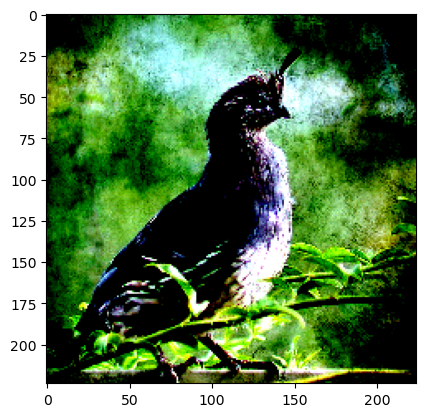

torch.Size([1, 1, 768])
titi: 1.0%


In [3]:
from torchvision.io import read_image
from matplotlib import pyplot as plt
preprocess = model_weights.transforms()
image = read_image("./test_image.jpg")
image = preprocess(image)
plt.imshow(image.permute(1, 2, 0))
plt.show()
batch = image.unsqueeze(0)

model.eval()
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = model_weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")